## Access Sentinel 2 Data on Planetary Computer

### Setup Instructions

This notebook is meant to run on Planetary Computer lab hub.

In [1]:
import dask.distributed
import dask.utils
import numpy as np
import planetary_computer as pc
import xarray as xr
from IPython.display import display
from pystac_client import Client

from odc.stac import configure_rio, stac_load


### Configuration

For now we need to manually supply band dtype and nodata information for each band in the collection. Use band named * as a wildcard.

In [51]:
cfg = {
    "sentinel-2-l2a": {
        "assets": {
            "*": {"data_type": "uint16", "nodata": 0},
            "SCL": {"data_type": "uint8", "nodata": 0},
            "visual": {"data_type": "uint8", "nodata": 0},
        },
    },
    "*": {"warnings": "ignore"},
}

### Start Dask Client

This step is optional, but it does improve load speed significantly. You don’t have to use Dask, as you can load data directly into memory of the notebook.

In [52]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, client=client)
display(client)

/home/hn/miniconda3/envs/geoenv/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36941 instead
  warnings.warn(
/home/hn/miniconda3/envs/geoenv/lib/python3.10/site-packages/distributed/client.py:1391: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | Client | Scheduler | Workers |
+---------+--------+-----------+---------+
| numpy   | 1.25.0 | 1.25.0    | 1.24.0  |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36941/status,
Dashboard: http://127.0.0.1:36941/status,Workers: 4
Total threads: 8,Total memory: 15.44 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42729,Workers: 4
Dashboard: http://127.0.0.1:36941/status,Total threads: 8
Started: Just now,Total memory: 15.44 GiB
Comm: tcp://127.0.0.1:45135,Total threads: 2
Dashboard: http://127.0.0.1:37551/status,Memory: 3.86 GiB
Nanny: tcp://127.0.0.1:33117,


### Query STAC API

Here we are looking for datasets in sentinel-2-l2a collection from June 2019 over MGRS tile 06VVN.

In [2]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

query = catalog.search(
    collections=["sentinel-2-l2a"],
    datetime="2019-06",
    query={"s2:mgrs_tile": dict(eq="06VVN")},
)

items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 23 datasets


### Lazy load all the bands

We won’t use all the bands but it doesn’t matter as bands that we won’t use won’t be loaded. We are “loading” data with Dask, which means that at this point no reads will be happening just yet.

If you were to skip warnings: ignore in the configuration, you’ll see a warning about rededge common name being used on several bands. Basically we can only work with common names that uniquely identify some band. In this case EO extension defines common name rededge for bands 5, 6 and 7.

In [54]:
cfg = {
    "sentinel-2-l2a": {
        "assets": {
            "*": {"data_type": "uint16", "nodata": 0},
            "SCL": {"data_type": "uint8", "nodata": 0},
            "visual": {"data_type": "uint8", "nodata": 0},
        },
    },
    "*": {"warnings": "ignore"},
}

resolution = 10
SHRINK = 4
if client.cluster.workers[0].memory_manager.memory_limit < dask.utils.parse_bytes("4G"):
    SHRINK = 8  # running on Binder with 2Gb RAM

if SHRINK > 1:
    resolution = resolution * SHRINK


Bands: AOT,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,SCL,WVP,visual


<xarray.Dataset>
Dimensions:      (y: 2745, x: 2745, time: 23)
Coordinates:
  * y            (y) float64 6.8e+06 6.8e+06 6.8e+06 ... 6.69e+06 6.69e+06
  * x            (x) float64 4e+05 4e+05 4.001e+05 ... 5.097e+05 5.097e+05
    spatial_ref  int32 32606
  * time         (time) datetime64[ns] 2019-06-01T21:15:21.024000 ... 2019-06...
Data variables: (12/16)
    AOT          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B01          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B02          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B05          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    ...           ...
    B11          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B12          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B8A          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    WVP          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    visual       (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

In [55]:
xx = stac_load(
    items,
    chunks={"x": 2048, "y": 2048},
    stac_cfg=cfg,
    patch_url=pc.sign,
    resolution=resolution,
)

print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)

Bands: AOT,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,SCL,WVP,visual


<xarray.Dataset>
Dimensions:      (y: 2745, x: 2745, time: 23)
Coordinates:
  * y            (y) float64 6.8e+06 6.8e+06 6.8e+06 ... 6.69e+06 6.69e+06
  * x            (x) float64 4e+05 4e+05 4.001e+05 ... 5.097e+05 5.097e+05
    spatial_ref  int32 32606
  * time         (time) datetime64[ns] 2019-06-01T21:15:21.024000 ... 2019-06...
Data variables: (12/16)
    AOT          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B01          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B02          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B05          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    ...           ...
    B11          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B12          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B8A          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    WVP          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    visual       (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

By default stac_load will return all the data bands using canonical asset names. But we can also request a subset of bands, by supplying bands= parameter. When going this route you can also use “common name” to refer to a band.

In this case we request red,green,blue,nir bands which are common names for bands B04,B03,B02,B08 and SCL band which is a canonical name.

In [42]:
xx = stac_load(
    items,
    bands=["red", "green", "blue", "nir", "SCL"],
    resolution=resolution,
    chunks={"x": 2048, "y": 2048},
    stac_cfg=cfg,
    patch_url=pc.sign,
)

print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)

Bands: red,green,blue,nir,SCL


<xarray.Dataset>
Dimensions:      (y: 2745, x: 2745, time: 23)
Coordinates:
  * y            (y) float64 6.8e+06 6.8e+06 6.8e+06 ... 6.69e+06 6.69e+06
  * x            (x) float64 4e+05 4e+05 4.001e+05 ... 5.097e+05 5.097e+05
    spatial_ref  int32 32606
  * time         (time) datetime64[ns] 2019-06-01T21:15:21.024000 ... 2019-06...
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

### Do some math with bands

In [43]:
def to_float(xx):
    _xx = xx.astype("float32")
    nodata = _xx.attrs.pop("nodata", None)
    if nodata is None:
        return _xx
    return _xx.where(xx != nodata)


def colorize(xx, colormap):
    return xr.DataArray(colormap[xx.data], coords=xx.coords, dims=(*xx.dims, "band"))

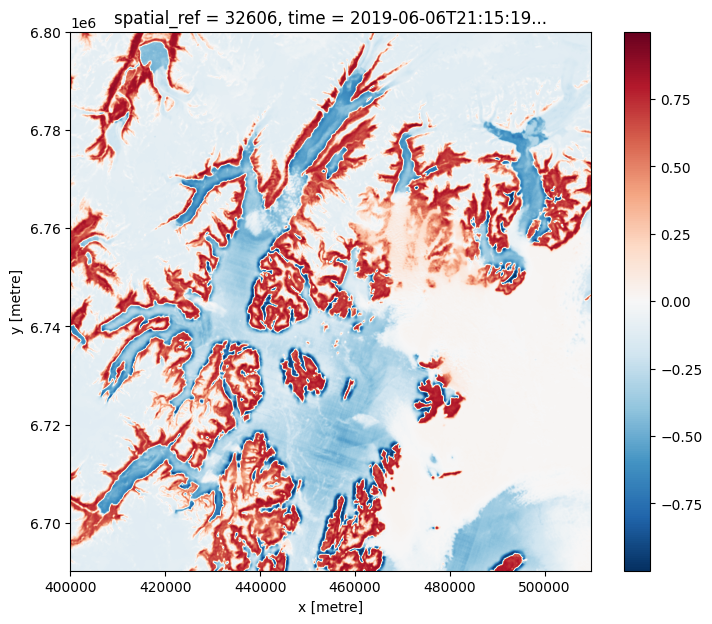

In [44]:
# like .astype(float32) but taking care of nodata->NaN mapping
nir = to_float(xx.nir)
red = to_float(xx.red)
ndvi = (nir - red) / (
    nir + red
)  # < This is still a lazy Dask computation (no data loaded yet)

# Get the 5-th time slice `load->compute->plot`
_ = ndvi.isel(time=4).compute().plot.imshow(size=7, aspect=1.2, interpolation="bicubic")

For sample purposes work with first 6 observations only

In [45]:
xx = xx.isel(time=np.s_[:6])

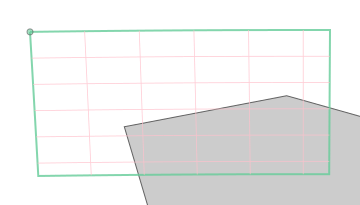

In [46]:
# fmt: off
scl_colormap = np.array(
    [
        [255,   0, 255, 255],  # 0  - NODATA
        [255,   0,   4, 255],  # 1  - Saturated or Defective
        [0  ,   0,   0, 255],  # 2  - Dark Areas
        [97 ,  97,  97, 255],  # 3  - Cloud Shadow
        [3  , 139,  80, 255],  # 4  - Vegetation
        [192, 132,  12, 255],  # 5  - Bare Ground
        [21 , 103, 141, 255],  # 6  - Water
        [117,   0,  27, 255],  # 7  - Unclassified
        [208, 208, 208, 255],  # 8  - Cloud
        [244, 244, 244, 255],  # 9  - Definitely Cloud
        [195, 231, 240, 255],  # 10 - Thin Cloud
        [222, 157, 204, 255],  # 11 - Snow or Ice
    ],
    dtype="uint8",
)
# fmt: on

# Load SCL band, then convert to RGB using color scheme above
scl_rgba = colorize(xx.SCL.compute(), scl_colormap)

# Check we still have geo-registration
scl_rgba.odc.geobox

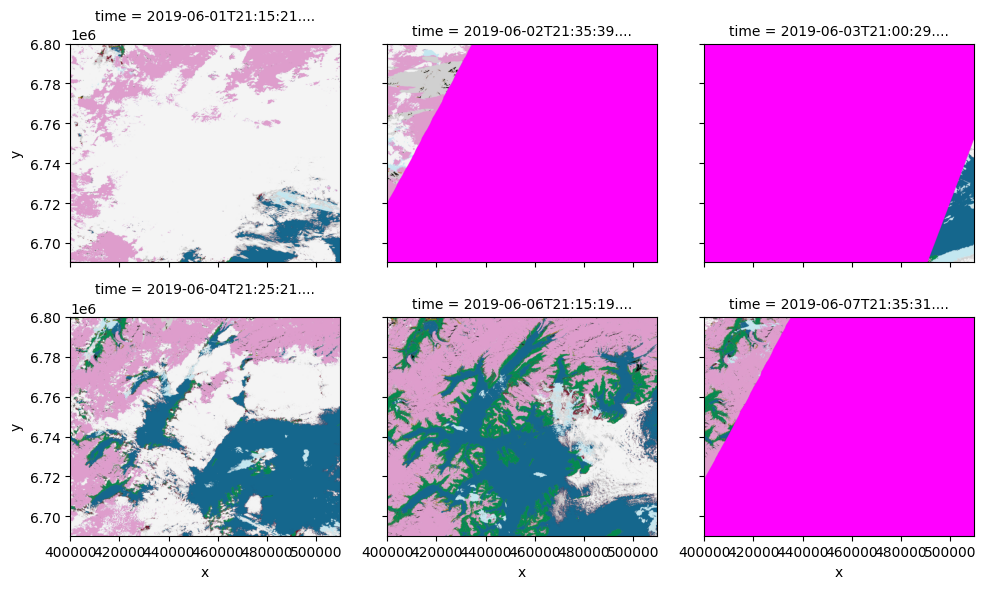

In [47]:
_ = scl_rgba.plot.imshow(col="time", col_wrap=3, size=3, interpolation="antialiased")

Let’s save image dated 2019-06-04 to a cloud optimized geotiff file.

In [48]:
to_save = scl_rgba.isel(time=3)
fname = f"SCL-{to_save.time.dt.strftime('%Y%m%d').item()}.tif"
print(f"Saving to: '{fname}'")

Saving to: 'SCL-20190604.tif'


In [49]:
scl_rgba.isel(time=3).odc.write_cog(
    fname,
    overwrite=True,
    compress="webp",
    webp_quality=90,
)

PosixPath('SCL-20190604.tif')

Check the file with rio info.

In [20]:
!ls -lh {fname}
!rio info {fname} | jq .

-rw-rw-r-- 1 hn hn 1,4M Nov  8 22:14 SCL-20190604.tif
{
  "blockxsize": 512,
  "blockysize": 512,
  "bounds": [
    399960,
    6690240,
    509760,
    6800040
  ],
  "colorinterp": [
    "red",
    "green",
    "blue",
    "alpha"
  ],
  "compress": "webp",
  "count": 4,
  "crs": "EPSG:32606",
  "descriptions": [
    null,
    null,
    null,
    null
  ],
  "driver": "GTiff",
  "dtype": "uint8",
  "height": 2745,
  "indexes": [
    1,
    2,
    3,
    4
  ],
  "interleave": "pixel",
  "lnglat": [
    -147.83041488908293,
    60.83899713274621
  ],
  "mask_flags": [
    [
      "per_dataset",
      "alpha"
    ],
    [
      "per_dataset",
      "alpha"
    ],
    [
      "per_dataset",
      "alpha"
    ],
    [
      "all_valid"
    ]
  ],
  "nodata": null,
  "res": [
    40,
    40
  ],
  "shape": [
    2745,
    2745
  ],
  "tiled": true,
  "transform": [
    40,
    0,
    399960,
    0,
    -40,
    6800040,
    0,
    0,
    1
  ],
  "units": [
    null,
    null,
    null,
 